#### Import packages and set plotting style.

In [ ]:
!pip install tqdm

In [ ]:
import os
import math

import numpy as np
import tensorflow as tf

from tqdm.notebook import trange
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt 

import pandas as pd

In [ ]:
# Plot Style
sns.reset_defaults()

mpl.style.use('seaborn-colorblind')
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['lines.marker'] = None
mpl.rcParams['axes.grid'] = True

DEFAULT_FONTSIZE = 17
mpl.rcParams.update({
    'font.size': DEFAULT_FONTSIZE,
    'lines.linewidth': 4,
    'legend.fontsize': DEFAULT_FONTSIZE,
    'axes.labelsize': DEFAULT_FONTSIZE,
    'xtick.labelsize': DEFAULT_FONTSIZE,
    'ytick.labelsize': DEFAULT_FONTSIZE,
    'figure.figsize': (6, 6/1.2) #(7, 7 / 1.61)
})

# Multi-input multi-output Networks (MIMO), Regression Example


In this notebook, we illustrate the idea of Multi-input multi-output Networks (MIMO) in a regression problem. This notebook is broken down into 4 sections:

* Definitions I: **Model & Data**
* Definitions II: **Bias Variance Trade-off**
* Main Experiment: **1D Regression**
* Additional Experiment: **Regression in Higher Dimension**

In section **Model & Data**, we illustrate a simple, minimal implementation of the MIMO model based on MLP, and introduce the data setting we consider (a low-dimensional sinusoidal curve embedded in higher-dimension). Then in section **Bias Variance Trade-off**, we derive the bias variance trade-off mentioned in Section 2 of the paper and provide corresponding python implementations.

In Section **1D Regression**, we reproduce the Figure 2 of the paper. 

Finally as an additinoal study, in Section **Regression in Higher Dimension**, we extend this example beyond 1D to show that similiar phenonmenon holds also in the higher dimension (64D in this notebook). Note that material in this last section is not included in the main text of the paper.


# Definitions I: Model & Data

## Define MIMO Model

As introduced in the paper, a MIMO model is simple to implement: It just involves expanding the dimension of the input and the output layers of an existing model.

In [ ]:
def create_mimo(architecture, data_dim=1, ens_size=1, activation='relu'):
  """Create a MIMO model by expanding input/ouput layer by ensemble size."""
  # The only modification needed by MIMO: expand input/output layer by ensemble size
  num_logits = 1  # Since this is a regression problem.
  inputs_size = data_dim * ens_size
  outputs_size = num_logits * ens_size

  # MIMO input: expand input layer by ensemble size.
  inputs = tf.keras.layers.Input(shape=(inputs_size,))

  # Use the classic MLP encoder.
  net = inputs
  net = tf.keras.layers.Flatten()(net)
  for units in architecture:
    net = tf.keras.layers.Dense(units, activation=activation)(net)

  # MIMO output: Expand output layer by ensemble size.
  outputs = tf.keras.layers.Dense(outputs_size, activation='linear')(net)
  mimo_mlp = tf.keras.models.Model(inputs=inputs, outputs=outputs)
  return mimo_mlp

## Define Data

We consider a regression problem on the California Housing dataset. The data has 8 features and the original consists of 17 000 data points in the training set and 3000 data points in the test set.

In [ ]:
def get_regression_data(dataset='/content/sample_data/california_housing_train.csv', batch_size=64, train=True):
  """
  Function to California housing dataset 
  
  Returns:
    y: (ndarray) Response, shape (n, 1)
    X: (ndarray) High-dimensional features obtained by projecting X0 to high dimension, shape (n, data_dim)
    tf_dataset: (tf.data.Dataset) A TF Dataset to be used for training loops.
  """

  data = pd.read_csv(dataset)
  if train:
    data = data.sample(1000) # sample 1000 datapoints if training data
  y = data['median_house_value'].to_numpy(dtype='float32')
  X_data = data.drop('median_house_value', axis=1)
  X_data.head()
  X = X_data.to_numpy('float32')
  X_data.head()
  y = np.expand_dims(y, axis=1)

  # Produce high-dimensional dataset.
  tf_dataset = tf.data.Dataset.from_tensor_slices((X, y))
  tf_dataset = tf_dataset.shuffle(1024).batch(batch_size)

  return X, y, tf_dataset



Visualize example data: 1D curve embedded in 64D space.

## Define Train/Eval Loops

In [ ]:
def get_train_step(ens_size):

  assert ens_size >= 1

  @tf.function
  def train_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:

      inputs = [x]
      targets = [y]

      for _ in range(ens_size-1):
        rd_index = tf.random.shuffle(tf.range(len(y)))
        shuffled_x = tf.gather(x, rd_index)
        shuffled_y = tf.gather(y, rd_index)
        inputs.append(shuffled_x)
        targets.append(shuffled_y)

      inputs = tf.concat(inputs, 1)
      targets = tf.concat(targets, 1)

      predictions = model(inputs, training=True)
      sq_loss = tf.reduce_mean(tf.square(targets-predictions))

    gradients = tape.gradient(sq_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return sq_loss
  
  return train_step

In [ ]:
def run_mimo_experiments(architecture=(32, 128), ens_sizes=(1, 2, 3, 4, 5),
                         lr=0.01, batch_size=32, n_epochs=2000,
                         data_dim=1, num_reps=20,
                         eval_epoch=2, print_epoch=-1):
  """Train MIMO model with different ensemble sizes over multiple random seeds.
  
  Args:
    architecture: (tuple of int) Number of units in each hidden layer the MIMO MLP model.
    ens_sizes: (tuple of int) Ensemble sizes for MIMO model to evaluate in experiments.
    lr: (float) Learning rate.
    batch_size: (int) Batch size used for training.
    n_epochs: (int) Number of training epochs.
    data_dim: (int) Dimensionality of the input features.
    data_noise: (float) The standard deviation of the observation noise in the data-generation mechanism.
    n_train: (int) Number of training examples.
    n_test: (int) Number of test examples.
    num_reps: (int) Number of repetitions to conduct for each ensemble size.
    eval_epoch: (int) Record eval results every eval_epoch.
    print_epoch: (int) Print eval results every print_epoch. Set to -1 to disable.

  Returns: 
    ytest: (ndarray) Response for testing data, shape (n, 1)
    ytest_pred: (dict) A nested dictionary storing evaluation result for each 
      repetition, each ensemble size, and for specified epochs.
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Create testing data.
  Xtest, ytest, _ = get_regression_data('/content/sample_data/california_housing_test.csv', 64, False)

  # Train MIMO models with different ensemble sizes over multiple random seeds.
  ytest_pred = {}

  for rep in range(num_reps):
    print('Repetition', rep)

    X, y, training_set = get_regression_data()

    ytest_pred[rep] = {}

    for ens_size_id in trange(len(ens_sizes)):
      # Specified ensemble size.
      ens_size = ens_sizes[ens_size_id]

      ytest_pred[rep][ens_size] = {}

      # Train a MIMO model.
      optimizer = tf.keras.optimizers.Adam(lr)
      mimo_mlp = create_mimo(architecture, data_dim=data_dim,
                             ens_size=ens_size, activation='relu')
      train_step = get_train_step(ens_size)

      for epoch in range(n_epochs):
        sq_loss = []
        for x, y in training_set:
          loss = train_step(mimo_mlp, optimizer, x, y)
          sq_loss.append(loss)

        if print_epoch > 0 and epoch % print_epoch == 0:
          print('[{:4d}] train sq. loss {:0.3f}'.format(epoch, np.mean(sq_loss)))

        if epoch % eval_epoch == 0:
          # Save testing performance.
          per_ens_member_ytest_pred = mimo_mlp(tf.tile(Xtest, (1, ens_size)))
          ytest_pred[rep][ens_size][epoch] = per_ens_member_ytest_pred  

  return ytest, ytest_pred

# Definitions II: Bias-Variance Trade-off

We have the following setting:


*   The goal is to predict some real-valued target $y$ from input feature vector $x$
*   The training set is denoted by $\mathcal{X} = \{(x_i, y_i)\}_{i=1}^n$ 
*   We denote by $\mathcal{P}$ the joint distribution of $(x, y)$
*   We learn a function $\hat{f}(\cdot; \mathcal{X})$ from the training data to minimize the squared error
$$
\min_{f} \frac{1}{2} \sum_{(x, y) \in \mathcal{X}} (y - f(x))^2
$$
where $f$ will typically be a neural network.
*  We evaluate the performance of $\hat{f}(\cdot; \mathcal{X})$ according to the generalization error
$$
\mathcal{E} = E_{(x, y) \sim \mathcal{P}}\big [\mathcal{E}(x,y) \big]
$$
with
$$
\mathcal{E}(x,y) = E_{\mathcal{X}}\big[ (y - \hat{f}(x; \mathcal{X}) )^2\big]
$$

We can develop $\mathcal{E}$ into the well-known squared bias and variance decompostion. Denoting $\bar{f}(x) = E_{\mathcal{X}}[\hat{f}(x; \mathcal{X})]$, we have:

$
\begin{eqnarray}
E_{\mathcal{X}}\big[ (y - \hat{f}(x; \mathcal{X}) )^2 \big]
&=& 
E_{\mathcal{X}}\big[ (y - \bar{f}(x) + \bar{f}(x) -  \hat{f}(x; \mathcal{X}) )^2 \big] \\
&=& 
E_{\mathcal{X}}\big[ (y - \bar{f}(x) + \bar{f}(x) -  \hat{f}(x; \mathcal{X}) )^2 \big] \\
&=& 
E_{\mathcal{X}}\big[ (y - \bar{f}(x))^ 2 \big] + 
E_{\mathcal{X}}\big[ (\bar{f}(x) -  \hat{f}(x; \mathcal{X}) )^2 \big]
+
2E_{\mathcal{X}}\big[(y - \bar{f}(x)) (\bar{f}(x) -  \hat{f}(x; \mathcal{X}) ) ] \\
&=& 
(y - \bar{f}(x))^ 2 + 
E_{\mathcal{X}}\big[ (\bar{f}(x) -  \hat{f}(x; \mathcal{X}) )^2 \big] + 0
%\quad(\mathrm{since}\ E_{\mathcal{X}}\big[(y - \bar{f}(x)) (\bar{f}(x) - \hat{f}(x; \mathcal{X}) ) ] = (y - \bar{f}(x)) E_{\mathcal{X}}\big[(\bar{f}(x) - \hat{f}(x; \mathcal{X}) ) ])
\\
&=& 
\mathrm{squared\_bias}(x,y) + \mathrm{variance}(x,y).
\end{eqnarray}
$

We can then readily obtain
$$
\mathcal{E} = E_{(x, y) \sim \mathcal{P}}\big [\mathrm{squared\_bias}(x,y) + \mathrm{variance}(x,y) \big]
$$

In the sequel, we will monitor the value of $\mathcal{E}$ over the course of the optimization, for different ensemble sizes of MIMO.

## Definitions: Squared Bias and Variance

We now consider how to compute the $\mathrm{squared\_bias}(x,y)$ and $\mathrm{variance}(x,y)$ terms using results from a simulation experiment. 

Assume we performed a simulation with $K$ repetitions. In each repetition, we sample a size $n$ dataset $\mathcal{X}_k \sim \mathcal{P}$ and train a model $\hat{f}(x; \mathcal{X}_k)$. We can then estimate the mean prediction as $\bar{f}(x) = \frac{1}{K}\sum_{k=1}^K \hat{f}(x, \mathcal{X}_k)$.

In [ ]:
compute_ens_mean = lambda ens_pred: tf.reduce_mean(ens_pred, axis=1, keepdims=True)

def compute_mean_prediction(y_ens_pred_runs):
  """Computes mean of MIMO model prediction from different experiment runs."""
  ens_pred_list = []
  for y_ens_pred in y_ens_pred_runs.values():
    # Compute mean of ensemble prediction for each repetition
    ens_pred = compute_ens_mean(y_ens_pred)
    ens_pred_list.append(ens_pred)

  return tf.reduce_mean(ens_pred_list, axis=0)

Then, we can estimate the squared bias term and the variance term as below:

$$\mathrm{squared\_bias}(x,y) = (y - \bar{f}(x))^ 2$$

$$\mathrm{variance}(x,y) = E_{\mathcal{X}}\big[ (\bar{f}(x) -  \hat{f}(x; \mathcal{X}) )^2 \big]$$

In [ ]:
def compute_squared_bias(y_test, y_ens_pred_runs):
  """Compute predictive squared bias over experiment repetitions."""
  y_pred_mean = compute_mean_prediction(y_ens_pred_runs)
  return tf.reduce_mean((ytest - y_pred_mean)**2)

def compute_variance(y_ens_pred_runs):
  """Compute predictive variance over experiment repetitions."""
  ens_pred_mean = compute_mean_prediction(y_ens_pred_runs)

  ens_var_list = []
  for y_ens_pred in y_ens_pred_runs.values():
    # Compute variance of ensemble prediction for each repetition
    ens_pred = compute_ens_mean(y_ens_pred)
    ens_var_list.append((ens_pred_mean - ens_pred)**2)

  return tf.reduce_mean(ens_var_list)

Using the above functions, we can write a routine to compute the model bias-variance tradeoff for the simulation experiment.

In [ ]:
def get_simulation_metadata(simu_result):
  """Extract number of repetitions, ensemble sizes and epoch ids from the simulation result."""
  rep_ids = list(simu_result.keys())
  ens_sizes = list(simu_result[rep_ids[0]].keys())
  epoch_ids = list(simu_result[rep_ids[0]][ens_sizes[0]].keys())
  return rep_ids, ens_sizes, epoch_ids
  

def compute_bias_variance_tradeoff(ytest, ytest_pred):
  """Computes bias-variance tradeoff for simulation result contained in ytest_pred."""
  # Extract information about ensemble sizes and epoch ids.
  rep_ids, ens_sizes, epoch_ids = get_simulation_metadata(ytest_pred)

  sq_biases = {}
  variances = {}
  for ens_size in ens_sizes:
    sq_bias_list = []
    var_list = []

    for epoch in epoch_ids:
      # Extract results over repetitions for a specific epoch and ensemble size
      ytest_pred_reps = {rep_id: ytest_pred[rep_id][ens_size][epoch] for rep_id in rep_ids}

      # compute bias and variance
      sq_bias = compute_squared_bias(ytest, ytest_pred_reps)
      variance = compute_variance(ytest_pred_reps)

      sq_bias_list.append(sq_bias)
      var_list.append(variance)

    sq_biases[ens_size] = np.array(sq_bias_list)
    variances[ens_size] = np.array(var_list)
  
  return sq_biases, variances

## Define Visualization Functions

We also implement a plotting routine to visualize the change of bias / variance / losses over the epochs.

In [ ]:
def plot_bias_variance_tradeoff(sq_biases, variances, ytest_pred, 
                                plot_type="bias", y_top=None, y_bottom=None, figsize=(9, 6)):
  
  rep_ids, ens_sizes, epoch_ids = get_simulation_metadata(ytest_pred)
  x_axis_epochs = np.array(epoch_ids) + 1

  plt.figure(figsize=figsize)
  for ens_size in ens_sizes:
    if plot_type == "bias":
      plt.plot(x_axis_epochs, np.log10(sq_biases[ens_size]), label='M={}'.format(ens_size))
      plot_ylabel = '$\\log_{10}(\\mathrm{squared\ bias})$'
    elif plot_type == "variance": 
      plt.plot(x_axis_epochs, np.log10(variances[ens_size]), label='M={}'.format(ens_size))
      plot_ylabel = '$\\log_{10}(\\mathrm{variance})$'
    elif plot_type == "loss":
      plt.plot(x_axis_epochs, np.log10(sq_biases[ens_size] + variances[ens_size]), label='ens. size {}'.format(ens_size))
      plot_ylabel = '$\\log_{10}(\\mathcal{E}_{\\mathrm{ens}})$'
    elif plot_type == "loss_diff": 
      single_model_loss = sq_biases[1] + variances[1]
      ensemble_model_loss = sq_biases[ens_size] + variances[ens_size]
      plt.plot(x_axis_epochs, np.log10(ensemble_model_loss) - np.log10(single_model_loss), label='M={}'.format(ens_size))
      plot_ylabel = '$\\log_{10}(\\mathcal{E}_{M})-\\log_{10}(\\mathcal{E}_{1})$'
    else:
      raise ValueError(f"Plot type {plot_type} not supported.")

  plt.legend()
  plt.ylim(top=y_top, bottom=y_bottom)
  plt.xlabel('epochs')
  plt.ylabel(plot_ylabel)
  plt.show()

# Regression in Higher Dimensions.

We train a multilayer perceptron with two hidden-layers, composed of (32, 128) units and ReLU activations. We evaluate both a single model, and MIMO models with ensemble sizes $M=2, \dots, 5$. 

For each ensemble size, we repeat the experiment 5 times and then compute the bias-variance trade-off over the experiment runs.

We consider a higher-dimensional setting by projecting the 1D feature into higher (64D) dimensions (as introduced in Section **Models & Data**).

### Run experiments

In [ ]:
# We use the same experiment setting as in the 1D experiment, 
# Changing data dimension from 1 to 8 (dimension of California housing dataset ),
# increase epoch sizes and reduce the frequency for logging results in order to save memory.

experiment_config_highdim = dict(
    data_dim=8, 
    architecture=(32, 128), 
    num_reps=10,
    lr=0.01,
    n_epochs=5000,
    eval_epoch=20,
    ens_sizes=(1,2,3,4,5))

In [ ]:
ytest, ytest_pred = run_mimo_experiments(**experiment_config_highdim)

Repetition 0


  0%|          | 0/5 [00:00<?, ?it/s]

Repetition 1


  0%|          | 0/5 [00:00<?, ?it/s]

Repetition 2


  0%|          | 0/5 [00:00<?, ?it/s]

Repetition 3


  0%|          | 0/5 [00:00<?, ?it/s]

Repetition 4


  0%|          | 0/5 [00:00<?, ?it/s]

Repetition 5


  0%|          | 0/5 [00:00<?, ?it/s]

Repetition 6


  0%|          | 0/5 [00:00<?, ?it/s]

Repetition 7


  0%|          | 0/5 [00:00<?, ?it/s]

Repetition 8


  0%|          | 0/5 [00:00<?, ?it/s]

Repetition 9


  0%|          | 0/5 [00:00<?, ?it/s]

### Visualized Bias-variance Trade-off in Higher Dimension.

We plot the model bias, variance and generalization error over the epochs as before.

As shown, we observed similar gains in variance for the MIMO model when compared to a single model, with the added advantage that the ensemble predictions are more stable in higher dimension.

In [ ]:
sq_biases, variances = compute_bias_variance_tradeoff(ytest, ytest_pred)

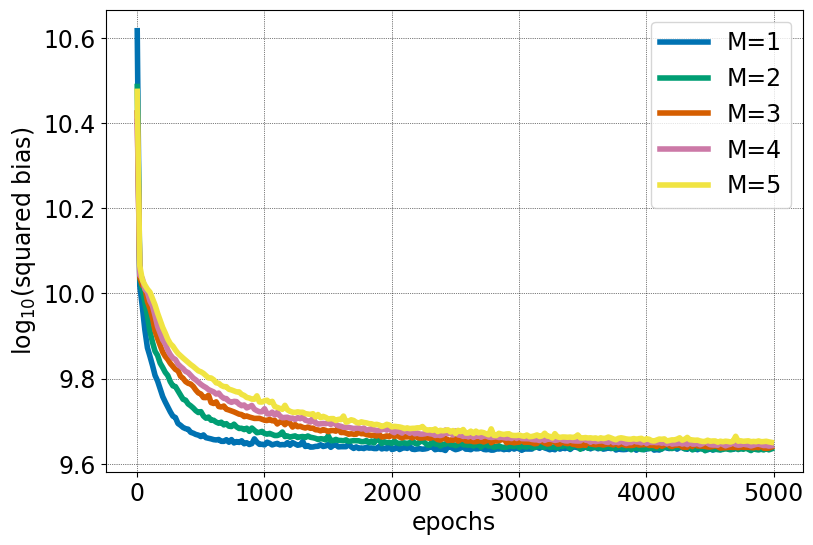

In [ ]:
plot_bias_variance_tradeoff(sq_biases, variances, ytest_pred, plot_type="bias")

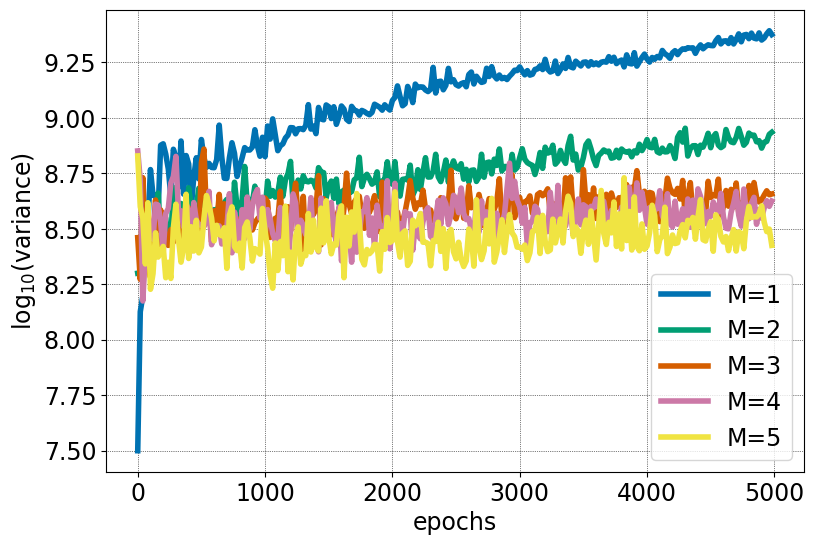

In [ ]:
plot_bias_variance_tradeoff(sq_biases, variances, ytest_pred, plot_type="variance")

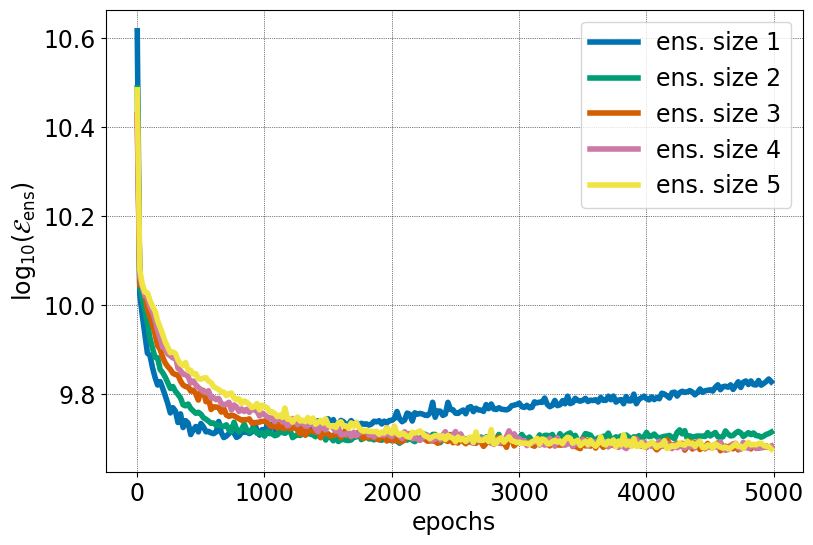

In [ ]:
plot_bias_variance_tradeoff(sq_biases, variances, ytest_pred, plot_type="loss")

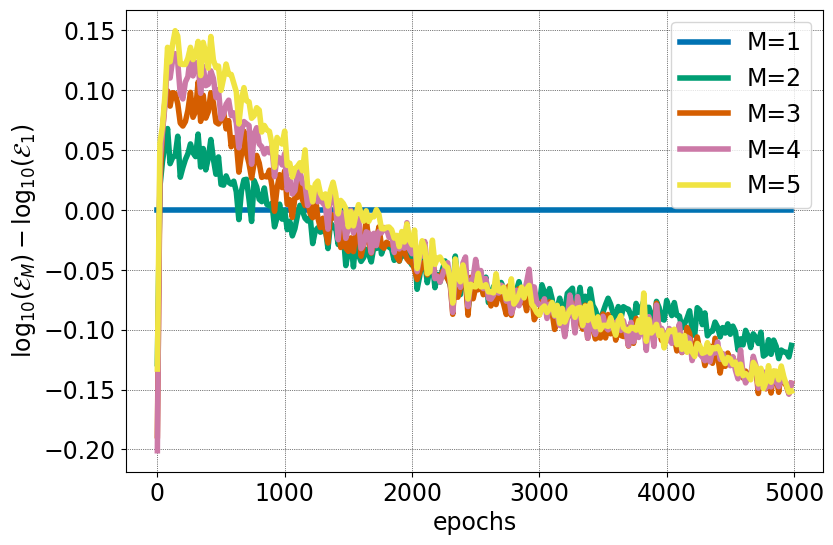

In [ ]:
plot_bias_variance_tradeoff(sq_biases, variances, ytest_pred, plot_type="loss_diff")